# Instance segmentation on strawberries dataset with active ML - demo

## Imports & Installs

In [1]:
# Check you have access to a GPU
!nvidia-smi

Thu Oct 26 18:18:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from IPython.display import clear_output

In [4]:
!pip install ultralytics && pip install pyyaml && pip install roboflow
clear_output()
# restart runtime

In [3]:
from roboflow import Roboflow
import glob
import os
import matplotlib.pyplot as plt
import yaml
import os
import cv2
import numpy as np
import random

## Import the dataset from Roboflow

In [4]:
rf = Roboflow(api_key="your_key")
project = rf.workspace("5060tanapoowapat-yumsarn").project("strawberry-2vs5u")
dataset = project.version(2).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.201, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to strawberry-2 in yolov8:: 100%|██████████| 7710/7710 [00:01<00:00, 5192.47it/s]


## Fixing the data.yaml file to work properly in colab and organize the data for our active ML demo.
We assume here that the original training set is our unlabeled set of images, the validation set is our testing data, and the test set is our labeled data because it has the fewest examples.


In [5]:
def rename_folders(current_folder_name, new_folder_name):
  # Check if the folder exists
  if os.path.exists(current_folder_name):
      # Rename the folder
      os.rename(current_folder_name, new_folder_name)
  else:
      print(f'The folder {current_folder_name} does not exist.')

dataset_name = 'strawberry-2'
rename_folders(current_folder_name=f'/content/{dataset_name}/train', new_folder_name=f'/content/{dataset_name}/unlabeled')
rename_folders(current_folder_name=f'/content/{dataset_name}/valid', new_folder_name=f'/content/{dataset_name}/testing')
rename_folders(current_folder_name=f'/content/{dataset_name}/test', new_folder_name=f'/content/{dataset_name}/labeled')

In [6]:
path_data_yaml = f'/content/{dataset_name}/data.yaml'

with open(path_data_yaml, 'r') as file:
    data = yaml.safe_load(file)
data['train'] = 'labeled/images'
data['val'] = ''
data['test'] = 'testing/images'
with open(path_data_yaml, 'w') as file:
    yaml.dump(data, file)

In [7]:
unlabeled_files = glob.glob(f'/content/{dataset_name}/unlabeled/images/*.jpg')
labeled_files = glob.glob(f'/content/{dataset_name}/labeled/images/*.jpg')
testing_files = glob.glob(f'/content/{dataset_name}/testing/images/*.jpg')

print(f"For our demo, we have {len(unlabeled_files)} unlabeled files, {len(labeled_files)} labeled files, and {len(testing_files)} testing files")

For our demo, we have 3006 unlabeled files, 184 labeled files, and 659 testing files


## Training

In [8]:
from ultralytics import YOLO
model = YOLO('yolov8n-seg.pt')

print('Start training ')
results = model.train(data=path_data_yaml,
                      batch=16,
                      task='segment',
                      mode='train',
                      epochs=10
                      )


100%|██████████| 6.73M/6.73M [00:00<00:00, 24.3MB/s]


Start training 


Ultralytics YOLOv8.0.201 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/strawberry-2/data.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscr

## Evaluation

In [9]:
metrics = model.val(data=path_data_yaml, split='test')

Ultralytics YOLOv8.0.201 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs
val: Scanning /content/strawberry-2/testing/labels.cache... 659 images, 1 backgrounds, 0 corrupt: 100%|██████████| 659/659 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:09<00:00,  4.36it/s]
                   all        659       1668      0.673       0.73      0.766      0.533      0.742      0.748      0.817      0.597
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train2


In [10]:
metrics.results_dict

{'metrics/precision(B)': 0.673169825129636,
 'metrics/recall(B)': 0.7297833796885302,
 'metrics/mAP50(B)': 0.7664149988792639,
 'metrics/mAP50-95(B)': 0.533442993245899,
 'metrics/precision(M)': 0.7415224838967787,
 'metrics/recall(M)': 0.7482014388489209,
 'metrics/mAP50(M)': 0.8165979711704425,
 'metrics/mAP50-95(M)': 0.5967313838152124,
 'fitness': 1.175458236359971}

## Active Learning loop

In [11]:
# Run the model on each image in the unlabeled set
results = model(os.path.join(f'/content/{dataset_name}/', 'unlabeled/images'),
                verbose=False, conf=0.25, task='segment')


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



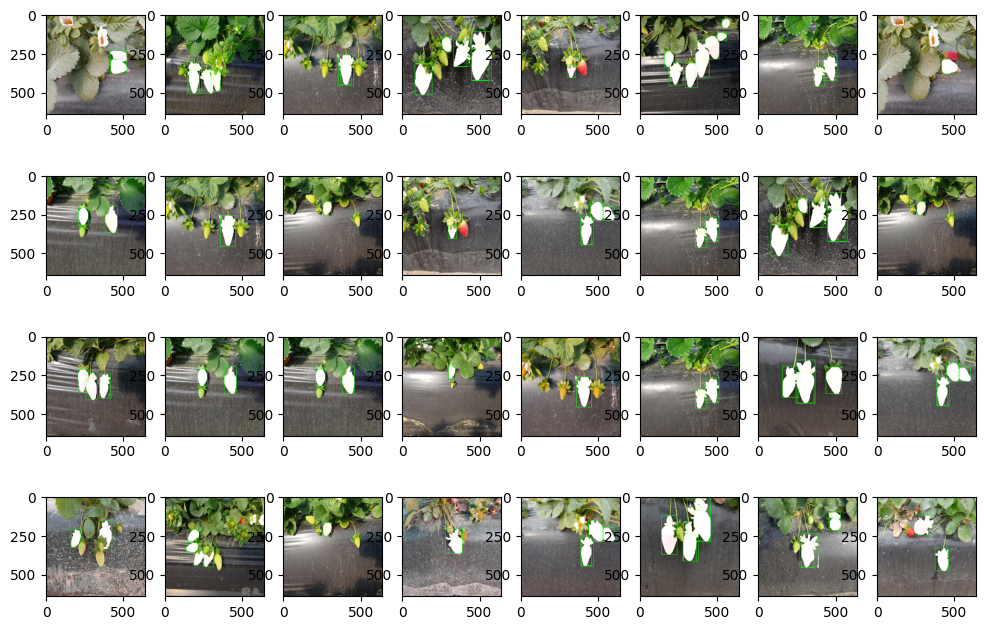

In [19]:
plt.figure(figsize=(12, 8))
# Generate a list of 32 random integers between 0 and 100
random_integers = [random.randint(0, 100) for _ in range(32)]
for i, index in enumerate(random_integers):
  plt.subplot(4,8,i+1)
  image = results[index].orig_img
  for b in results[index].boxes.xywhn:
    x, y, w, h = b.tolist()
    # Convert YOLO format coordinates to OpenCV format coordinates
    dh, dw, _ = image.shape
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    cv2.rectangle(image, (l, t), (r, b), (0, 255, 0), 2)

  if results[index].masks:
    overlayed_image = image.copy()
    for m in results[index].masks:
      # Make sure both images are of data type uint8
      mask = np.array(m.data.cpu()[0])
      mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
      image = image.astype(np.uint8)
      mask = mask*255
      mask = mask.astype(np.uint8)

      # Overlay the mask on the RGB image
      overlayed_image = cv2.addWeighted(overlayed_image, 1, mask, 0.8, 0)

  plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))

plt.show()

In [21]:
confidences = []
for result in results:
  confidences.append(result.boxes.conf)

In [22]:
len(confidences)

3006

In [23]:
confidence_scores = []
for confidence in confidences:
  if len(confidence) > 0:
    confidence_scores.append(np.min(np.array(confidence.cpu())))
  else:
    confidence_scores.append(10)

In [24]:
len(confidence_scores)

3006

In [25]:
import torch
# Number of queries we want to select from the unlabeled set
num_queries = 500

# Sort by uncertainty
sorted_uncertainties, indices = torch.sort(torch.tensor(confidence_scores))

# Get original indices of most uncertain samples
most_uncertain_indices = indices[-num_queries:]

print(f"sorted_uncertainties: {sorted_uncertainties[0:num_queries]} \nmost_uncertain_indices selected: {most_uncertain_indices}\n")

sorted_uncertainties: tensor([0.2500, 0.2501, 0.2501, 0.2501, 0.2501, 0.2502, 0.2503, 0.2503, 0.2503, 0.2503, 0.2503, 0.2504, 0.2505, 0.2506, 0.2506, 0.2506, 0.2507, 0.2507, 0.2507, 0.2508, 0.2508, 0.2508, 0.2508, 0.2509, 0.2509, 0.2510, 0.2510, 0.2511, 0.2511, 0.2512, 0.2512, 0.2512, 0.2513, 0.2513, 0.2513, 0.2513, 0.2513, 0.2514, 0.2514,
        0.2514, 0.2514, 0.2514, 0.2515, 0.2515, 0.2515, 0.2516, 0.2516, 0.2517, 0.2518, 0.2518, 0.2518, 0.2519, 0.2519, 0.2519, 0.2519, 0.2520, 0.2520, 0.2520, 0.2520, 0.2520, 0.2520, 0.2521, 0.2522, 0.2523, 0.2523, 0.2525, 0.2525, 0.2526, 0.2526, 0.2527, 0.2527, 0.2527, 0.2527, 0.2529, 0.2529, 0.2529, 0.2530, 0.2530,
        0.2530, 0.2531, 0.2531, 0.2531, 0.2531, 0.2531, 0.2532, 0.2532, 0.2533, 0.2533, 0.2533, 0.2535, 0.2535, 0.2536, 0.2536, 0.2536, 0.2537, 0.2538, 0.2538, 0.2538, 0.2538, 0.2539, 0.2539, 0.2539, 0.2540, 0.2541, 0.2541, 0.2541, 0.2541, 0.2542, 0.2542, 0.2542, 0.2543, 0.2544, 0.2544, 0.2545, 0.2545, 0.2546, 0.2546,
        0.2547, 0.

### Select the images

In [26]:
images_selected = np.array(glob.glob(os.path.join(f'/content/{dataset_name}/', 'unlabeled/images', '*.jpg')))[np.array(most_uncertain_indices)]

In [27]:
len(images_selected)

500

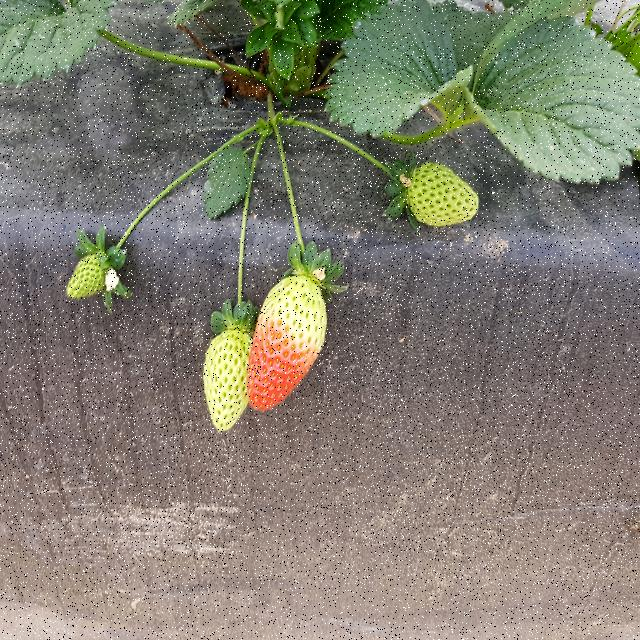

In [28]:
from PIL import Image
Image.open(images_selected[0])

In [29]:
images_labeled = glob.glob(f'/content/{dataset_name}/labeled/images/*.jpg')
len(images_labeled)

184

In [30]:
labels_labeled = glob.glob(f'/content/{dataset_name}/labeled/labels/*.txt')
len(labels_labeled)

184

In [31]:
import shutil

for image_path in images_selected:
  shutil.move(image_path, image_path.replace('unlabeled', 'labeled'))
  label_file = image_path.replace('images', 'labels').replace('.jpg', '.txt')
  shutil.move(label_file, label_file.replace('unlabeled', 'labeled'))

In [32]:
images_labeled = glob.glob(f'/content/{dataset_name}/labeled/images/*.jpg')
len(images_labeled)

684

In [33]:
labels_labeled = glob.glob(f'/content/{dataset_name}/labeled/labels/*.txt')
len(labels_labeled)

684

### Train again

In [34]:
model = YOLO('yolov8n-seg.pt')

print('Start training ')
results = model.train(data=path_data_yaml,
                      batch=16,
                      task='segment',
                      mode='train',
                      epochs=10
                      )


Ultralytics YOLOv8.0.201 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/strawberry-2/data.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchsc

Start training 


  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  
 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

In [35]:
metrics = model.val(data=path_data_yaml, split='test')
metrics.results_dict

Ultralytics YOLOv8.0.201 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs
val: Scanning /content/strawberry-2/testing/labels.cache... 659 images, 1 backgrounds, 0 corrupt: 100%|██████████| 659/659 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:09<00:00,  4.40it/s]
                   all        659       1668      0.752      0.757      0.801      0.608      0.806      0.807      0.851      0.655
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/segment/train32


{'metrics/precision(B)': 0.7522007556106134,
 'metrics/recall(B)': 0.7570614064930203,
 'metrics/mAP50(B)': 0.800552933790843,
 'metrics/mAP50-95(B)': 0.6079730626509038,
 'metrics/precision(M)': 0.8061734224988162,
 'metrics/recall(M)': 0.8069544364508393,
 'metrics/mAP50(M)': 0.8511208111235853,
 'metrics/mAP50-95(M)': 0.6554160034789296,
 'fitness': 1.3022175340082929}